In [ ]:
############################  GLOBAL

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# **Set Device to a Specific GPU (e.g., GPU 1)**
device_index = 3  # Change to appropriate index
torch.cuda.set_device(device_index)
device = torch.device(f"cuda:{device_index}")
print(f"Using GPU: {torch.cuda.get_device_name(device_index)}")

# **File names for 22 clients**
file_names = [f"11_sequences_{i},{j}_processed_UPDATED.csv" for i in range(1, 12) for j in range(1, 3)]

# **Training Settings**
epochs = 1000  # Total number of epochs
batch_size = 32

# **Performance Tracking**
train_loss_log = []  # Track training loss
val_loss_log = []    # Track validation loss

# **Communication Overhead**
communication_overhead = 0  # Track data sent to the central server

# **Define PyTorch Model with TCN and Residual Connections**
class TCNModel(nn.Module):
    def __init__(self):
        super(TCNModel, self).__init__()

        # **TCN Block**
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # **Residual Connection**
        self.conv_res = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1, padding='same')

        # **LSTM Block**
        self.lstm1 = nn.LSTM(input_size=16, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=32, batch_first=True)

        # **Prediction Heads**
        # Traffic Prediction Head
        self.traffic_lstm1 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.traffic_lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.traffic_out = nn.Linear(32, 1)

        # User Prediction Head
        self.user_lstm1 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.user_lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.user_out = nn.Linear(32, 1)

    def forward(self, x):
        # **TCN Block**
        x = x.permute(0, 2, 1)  # Convert to (batch, features, timesteps)
        tcn = self.conv1(x)
        tcn = self.batch_norm1(tcn)
        tcn = self.relu(tcn)
        tcn = self.dropout(tcn)

        # **Residual Connection**
        res = self.conv_res(tcn)
        tcn = tcn + res  # Add residual connection

        # **LSTM Block**
        tcn = tcn.permute(0, 2, 1)  # Convert back to (batch, timesteps, features)
        lstm_out, _ = self.lstm1(tcn)
        lstm_out, _ = self.lstm2(lstm_out)

        # **Traffic Prediction Head**
        traffic_out, _ = self.traffic_lstm1(lstm_out)
        traffic_out, _ = self.traffic_lstm2(traffic_out)
        traffic_out = self.traffic_out(traffic_out[:, -1, :])  # Use last timestep

        # **User Prediction Head**
        user_out, _ = self.user_lstm1(lstm_out)
        user_out, _ = self.user_lstm2(user_out)
        user_out = self.user_out(user_out[:, -1, :])  # Use last timestep

        return traffic_out, user_out

# **Aggregate Data from All Clients**
X_all = []
y2_all = []
y3_all = []

for file_name in file_names:
    print(f"Loading data from: {file_name}")
    seq = pd.read_csv(f'/home/roo/Desktop/Jaffar/CL/{file_name}', header=None)
    X_raw = seq.iloc[:, :3].values
    y2, y3 = seq.iloc[:, -2].values, seq.iloc[:, -1].values

    # Normalize labels
    scaler_users = StandardScaler().fit(y2.reshape(-1, 1))
    scaler_traffic = StandardScaler().fit(y3.reshape(-1, 1))
    y2 = scaler_users.transform(y2.reshape(-1, 1)).flatten()
    y3 = scaler_traffic.transform(y3.reshape(-1, 1)).flatten()

    # Convert Data to PyTorch Tensors
    X = np.array([[eval(entry) if isinstance(entry, str) else entry for entry in row] for row in X_raw])
    X = X.reshape(X.shape[0], 3, 8)  # Reshape to (samples, timesteps, features)

    X_all.append(X)
    y2_all.append(y2)
    y3_all.append(y3)

    # Calculate communication overhead (data sent to the server)
    communication_overhead += X.nbytes + y2.nbytes + y3.nbytes

# Combine all data
X_all = np.concatenate(X_all, axis=0)
y2_all = np.concatenate(y2_all, axis=0)
y3_all = np.concatenate(y3_all, axis=0)

# Split into training and validation sets
X_train, X_test, y_train_user, y_test_user, y_train_traffic, y_test_traffic = train_test_split(
    X_all, y2_all.reshape(-1, 1), y3_all.reshape(-1, 1), test_size=0.2, random_state=42
)

# Convert to PyTorch Datasets
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                              torch.tensor(y_train_traffic, dtype=torch.float32),
                              torch.tensor(y_train_user, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                            torch.tensor(y_test_traffic, dtype=torch.float32),
                            torch.tensor(y_test_user, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# **Initialize Model**
model = TCNModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.005)
loss_fn = nn.L1Loss()

# **Track Training Time**
total_training_time = 0

# **Training Loop**
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    epoch_start_time = time.time()

    for batch in train_loader:
        X_batch, y_traffic_batch, y_user_batch = batch
        X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

        optimizer.zero_grad()
        traffic_out, user_out = model(X_batch)
        
        loss_traffic = loss_fn(traffic_out, y_traffic_batch)
        loss_user = loss_fn(user_out, y_user_batch)
        loss = loss_traffic + loss_user
        
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    train_loss_log.append(epoch_loss / len(train_loader))

    # Validation Loss Calculation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            X_batch, y_traffic_batch, y_user_batch = batch
            X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

            traffic_out, user_out = model(X_batch)

            loss_traffic = loss_fn(traffic_out, y_traffic_batch)
            loss_user = loss_fn(user_out, y_user_batch)
            loss = loss_traffic + loss_user

            val_loss += loss.item()

    val_loss_log.append(val_loss / len(val_loader))

    # Track epoch training time
    epoch_training_time = time.time() - epoch_start_time
    total_training_time += epoch_training_time

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss_log[-1]:.4f}, Val Loss: {val_loss_log[-1]:.4f}")

# **Save results to CSV**
results_df = pd.DataFrame({
    'Epoch': np.arange(1, epochs + 1),
    'Train Loss': train_loss_log,
    'Validation Loss': val_loss_log,
    'Communication Overhead (bytes)': [communication_overhead] * epochs,
    'Memory Usage (bytes)': [sum(p.numel() * p.element_size() for p in model.parameters())] * epochs,
    'Total Training Time (sec)': [total_training_time] * epochs
})
results_df.to_csv("global_learning_results_torch.csv", index=False)

# **Print total communication overhead & memory usage**
print(f"Total Communication Overhead: {communication_overhead} bytes")
print(f"Total Memory Usage: {sum(p.numel() * p.element_size() for p in model.parameters())} bytes")
print(f"Total Training Time: {total_training_time:.2f} seconds")

# **Plot Training vs. Validation Loss**
plt.figure(figsize=(10, 5))
plt.plot(results_df['Epoch'], results_df['Train Loss'], label="Training Loss", linewidth=2)
plt.plot(results_df['Epoch'], results_df['Validation Loss'], label="Validation Loss", linewidth=2, linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (Global Learning - PyTorch)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
######## FL #########################
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# **Set Device to a Specific GPU (e.g., GPU 1)**
device_index = 1  # Change to appropriate index
torch.cuda.set_device(device_index)
device = torch.device(f"cuda:{device_index}")
print(f"Using GPU: {torch.cuda.get_device_name(device_index)}")

# **File names for 22 clients**
file_names = [f"11_sequences_{i},{j}_processed_UPDATED.csv" for i in range(1, 12) for j in range(1, 3)]

# **Training Settings**
epochs_per_round = 50
num_rounds = 20
total_epochs = epochs_per_round * num_rounds

# **Performance Tracking**
train_loss_log = np.zeros((num_rounds, epochs_per_round))
val_loss_log = np.zeros((num_rounds, epochs_per_round))

# np.mean(epoch_val_losses, axis=0)  # NEW: Store validation loss

epoch_training_times = np.zeros(num_rounds)  
communication_overhead = 0

# **Define PyTorch Model**
class FLModel(nn.Module):
    def __init__(self):
        super(FLModel, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=3, out_channels=512, kernel_size=3, padding=2)  
        self.batch_norm = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        self.lstm1 = nn.LSTM(input_size=512, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=512, batch_first=True)

        # Prediction heads
        self.traffic_lstm1 = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        self.traffic_lstm2 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True)
        self.traffic_out = nn.Linear(32, 1)

        self.user_lstm1 = nn.LSTM(input_size=512, hidden_size=128, batch_first=True)
        self.user_lstm2 = nn.LSTM(input_size=128, hidden_size=32, batch_first=True)
        self.user_out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Ensure LSTM receives (batch_size, sequence_length, features)
        x = x.permute(0, 2, 1)  # Convert from (batch, features, seq) -> (batch, seq, features)

        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)

        traffic_x, _ = self.traffic_lstm1(x)
        traffic_x, _ = self.traffic_lstm2(traffic_x)
        traffic_out = self.traffic_out(traffic_x[:, -1, :])  # Output last time step

        user_x, _ = self.user_lstm1(x)
        user_x, _ = self.user_lstm2(user_x)
        user_out = self.user_out(user_x[:, -1, :])

        return traffic_out, user_out

# **Initialize Global Model**
global_model = FLModel().to(device)  

# **Start tracking total training time**
round_training_times = []
total_memory_usage = sum(p.numel() * p.element_size() for p in global_model.parameters())

# **Federated Learning Process**
for round_num in range(num_rounds):
    print(f"\n🚀 Federated Learning Round {round_num + 1}/{num_rounds}")

    client_training_times = []  
    epoch_train_losses = np.zeros((len(file_names), epochs_per_round))
    epoch_val_losses = np.zeros((len(file_names), epochs_per_round))  # NEW: Track validation loss
 
    round_communication_overhead = 0  

    # **Store Client Models**
    client_models = []  

    for client_idx, file_name in enumerate(file_names):
        print(f"Training client on: {file_name}")
        client_start_time = time.time()  

        # Load Data
        seq = pd.read_csv(f'/home/roo/Desktop/Jaffar/CL/{file_name}', header=None)
        X_raw = seq.iloc[:, :3].values
        y2, y3 = seq.iloc[:, -2].values, seq.iloc[:, -1].values

        # Normalize labels
        scaler_users = StandardScaler().fit(y2.reshape(-1, 1))
        scaler_traffic = StandardScaler().fit(y3.reshape(-1, 1))
        y2 = scaler_users.transform(y2.reshape(-1, 1)).flatten()
        y3 = scaler_traffic.transform(y3.reshape(-1, 1)).flatten()

        # Convert Data to PyTorch Tensors
        X = np.array([[eval(entry) if isinstance(entry, str) else entry for entry in row] for row in X_raw])
        X = X.reshape(X.shape[0], 3, 8)  

        X_train, X_test, y_train_user, y_test_user, y_train_traffic, y_test_traffic = train_test_split(
            X, y2.reshape(-1, 1), y3.reshape(-1, 1), test_size=0.2, random_state=42
        )

        # Convert to PyTorch Datasets
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                      torch.tensor(y_train_traffic, dtype=torch.float32),
                                      torch.tensor(y_train_user, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        
                # ADD VALIDATION DATASET
        val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                                    torch.tensor(y_test_traffic, dtype=torch.float32),
                                    torch.tensor(y_test_user, dtype=torch.float32))
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No shuffle for validation
        

        # Create & Train Local Model
        model = FLModel().to(device)  
        model.load_state_dict(global_model.state_dict())  

        optimizer = optim.Adam(model.parameters(), lr=0.005)
        loss_fn = nn.L1Loss()

        # Train Model
        for epoch in range(epochs_per_round):
            model.train()
            epoch_loss = 0.0
            for batch in train_loader:
                X_batch, y_traffic_batch, y_user_batch = batch
                X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

                optimizer.zero_grad()
                traffic_out, user_out = model(X_batch)
                
                loss_traffic = loss_fn(traffic_out, y_traffic_batch)
                loss_user = loss_fn(user_out, y_user_batch)
                loss = loss_traffic + loss_user
                
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()

            epoch_train_losses[client_idx, epoch] = epoch_loss / len(train_loader)
             # NEW: Validation Loss Calculation
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch in val_loader:
                    X_batch, y_traffic_batch, y_user_batch = batch
                    X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

                    traffic_out, user_out = model(X_batch)

                    loss_traffic = loss_fn(traffic_out, y_traffic_batch)
                    loss_user = loss_fn(user_out, y_user_batch)
                    loss = loss_traffic + loss_user

                    val_loss += loss.item()

            epoch_val_losses[client_idx, epoch] = val_loss / len(val_loader)  # Store validation loss
        
                # Compute communication overhead: Share **ALL** model parameters (in bytes)
        shared_params = sum(p.numel() * p.element_size() for p in model.parameters())
        round_communication_overhead += shared_params

        
        client_training_times.append(time.time() - client_start_time)  
        client_models.append(model)  

    # **Global Model Aggregation**
    global_state_dict = global_model.state_dict()
    for key in global_state_dict.keys():
        global_state_dict[key] = torch.stack(
            [client_model.state_dict()[key].float() for client_model in client_models], dim=0
        ).mean(dim=0)
    
    
    # Accumulate total communication overhead across rounds
    communication_overhead += round_communication_overhead

    global_model.load_state_dict(global_state_dict)  

    # Compute losses across clients
    train_loss_log[round_num] = np.mean(epoch_train_losses, axis=0)
    val_loss_log[round_num] = np.mean(epoch_val_losses, axis=0)  # NEW: Store validation loss

    # Track training time
    max_client_time = max(client_training_times)
    epoch_training_times[round_num] = max_client_time
    round_training_times.append(max_client_time)

# **Save results to CSV**
total_training_time = sum(round_training_times)

results_df = pd.DataFrame({
    'Epoch': np.arange(1, total_epochs + 1),
    'Training Time (sec)': np.repeat(epoch_training_times, epochs_per_round),
    'Train Loss': train_loss_log.flatten(),
    'Validation Loss': val_loss_log.flatten(),  # NEW: Add validation loss
    'Communication Overhead (bytes)': [communication_overhead] * total_epochs,
    'Memory Usage (bytes)': [total_memory_usage] * total_epochs,
    'Total Training Time (sec)': [total_training_time] * total_epochs
})
results_df.to_csv("federated_learning_resultsv2.csv", index=False)#lts_df.to_csv("federated_learning_results.csv", index=False)

# **Print total communication overhead & memory usage**
print(f"Total Communication Overhead: {communication_overhead} bytes")
print(f"Total Memory Usage: {total_memory_usage} bytes")
print(f"Total Training Time: {total_training_time:.2f} seconds")


import matplotlib.pyplot as plt

# Create x-axis (epoch numbers)
epochs = np.arange(1, total_epochs + 1)

# Flatten the loss logs
train_losses = train_loss_log.flatten()
val_losses = val_loss_log.flatten()

# Plot Training vs. Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label="Training Loss", linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", linewidth=2, linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()



Using GPU: NVIDIA GeForce RTX 4090

🚀 Training Client 1/22 on: 11_sequences_1,1_processed_UPDATED.csv

🚀 Training Client 2/22 on: 11_sequences_1,2_processed_UPDATED.csv

🚀 Training Client 3/22 on: 11_sequences_2,1_processed_UPDATED.csv

🚀 Training Client 4/22 on: 11_sequences_2,2_processed_UPDATED.csv

🚀 Training Client 5/22 on: 11_sequences_3,1_processed_UPDATED.csv

🚀 Training Client 6/22 on: 11_sequences_3,2_processed_UPDATED.csv

🚀 Training Client 7/22 on: 11_sequences_4,1_processed_UPDATED.csv

🚀 Training Client 8/22 on: 11_sequences_4,2_processed_UPDATED.csv

🚀 Training Client 9/22 on: 11_sequences_5,1_processed_UPDATED.csv

🚀 Training Client 10/22 on: 11_sequences_5,2_processed_UPDATED.csv

🚀 Training Client 11/22 on: 11_sequences_6,1_processed_UPDATED.csv

🚀 Training Client 12/22 on: 11_sequences_6,2_processed_UPDATED.csv

🚀 Training Client 13/22 on: 11_sequences_7,1_processed_UPDATED.csv

🚀 Training Client 14/22 on: 11_sequences_7,2_processed_UPDATED.csv

🚀 Training Client 15/

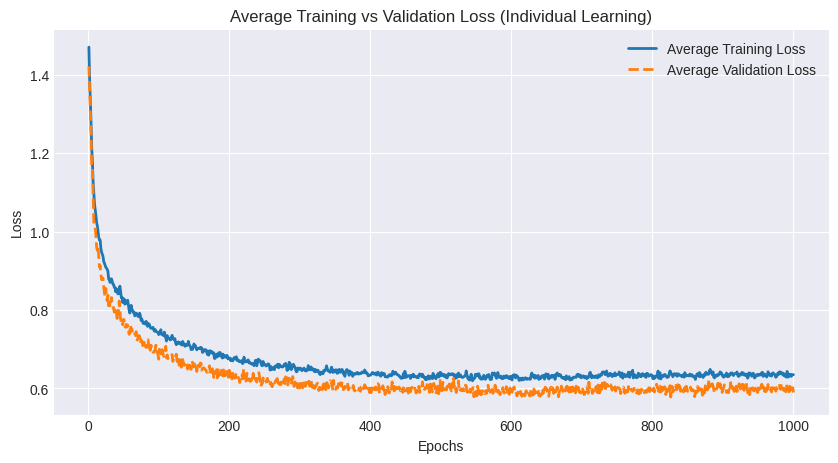

In [96]:
######################   IDEL


import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import sys
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# **Set Device to a Specific GPU (e.g., GPU 1)**
device_index = 1  # Change to appropriate index
torch.cuda.set_device(device_index)
device = torch.device(f"cuda:{device_index}")
print(f"Using GPU: {torch.cuda.get_device_name(device_index)}")

# **File names for 22 clients**
file_names = [f"11_sequences_{i},{j}_processed_UPDATED.csv" for i in range(1, 12) for j in range(1, 3)]

# **Training Settings**
epochs_per_round = 50
num_rounds = 20
total_epochs = 1000 #epochs_per_round * num_rounds

# **Performance Tracking**
train_loss_log = np.zeros((len(file_names), total_epochs))  # Track training loss for each client
val_loss_log = np.zeros((len(file_names), total_epochs))    # Track validation loss for each client

epoch_training_times = np.zeros(total_epochs)  
communication_overhead = 0

# **Define PyTorch Model**
class ILModel(nn.Module):
    def __init__(self):
        super(ILModel, self).__init__()
        
        # **TCN Block**
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # **Residual Connection**
        self.conv_res = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1, padding='same')

        # **LSTM Block**
        self.lstm1 = nn.LSTM(input_size=16, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=32, batch_first=True)

        # **Prediction Heads**
        # Traffic Prediction Head
        self.traffic_lstm1 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.traffic_lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.traffic_out = nn.Linear(32, 1)

        # User Prediction Head
        self.user_lstm1 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.user_lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.user_out = nn.Linear(32, 1)

    def forward(self, x):
        # **TCN Block**
        x = x.permute(0, 2, 1)  # Convert to (batch, features, timesteps)
        tcn = self.conv1(x)
        tcn = self.batch_norm1(tcn)
        tcn = self.relu(tcn)
        tcn = self.dropout(tcn)

        # **Residual Connection**
        res = self.conv_res(tcn)
        tcn = tcn + res  # Add residual connection

        # **LSTM Block**
        tcn = tcn.permute(0, 2, 1)  # Convert back to (batch, timesteps, features)
        lstm_out, _ = self.lstm1(tcn)
        lstm_out, _ = self.lstm2(lstm_out)

        # **Traffic Prediction Head**
        traffic_out, _ = self.traffic_lstm1(lstm_out)
        traffic_out, _ = self.traffic_lstm2(traffic_out)
        traffic_out = self.traffic_out(traffic_out[:, -1, :])  # Use last timestep

        # **User Prediction Head**
        user_out, _ = self.user_lstm1(lstm_out)
        user_out, _ = self.user_lstm2(user_out)
        user_out = self.user_out(user_out[:, -1, :])  # Use last timestep

        return traffic_out, user_out


# **Start tracking total training time**
client_training_times = []  # Track training time for each client
total_memory_usage = 0

# **Individual Learning Process**
for client_idx, file_name in enumerate(file_names):
    print(f"\n🚀 Training Client {client_idx + 1}/{len(file_names)} on: {file_name}")

    # Load Data
    seq = pd.read_csv(f'/home/roo/Desktop/Jaffar/CL/{file_name}', header=None)
    X_raw = seq.iloc[:, :3].values
    y2, y3 = seq.iloc[:, -2].values, seq.iloc[:, -1].values

    # Normalize labels
    scaler_users = StandardScaler().fit(y2.reshape(-1, 1))
    scaler_traffic = StandardScaler().fit(y3.reshape(-1, 1))
    y2 = scaler_users.transform(y2.reshape(-1, 1)).flatten()
    y3 = scaler_traffic.transform(y3.reshape(-1, 1)).flatten()

    # Convert Data to PyTorch Tensors
    X = np.array([[eval(entry) if isinstance(entry, str) else entry for entry in row] for row in X_raw])
    X = X.reshape(X.shape[0], 3, 8)  

    X_train, X_test, y_train_user, y_test_user, y_train_traffic, y_test_traffic = train_test_split(
        X, y2.reshape(-1, 1), y3.reshape(-1, 1), test_size=0.2, random_state=42
    )

    # Convert to PyTorch Datasets
    train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                                  torch.tensor(y_train_traffic, dtype=torch.float32),
                                  torch.tensor(y_train_user, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    
    # Validation Dataset
    val_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                                torch.tensor(y_test_traffic, dtype=torch.float32),
                                torch.tensor(y_test_user, dtype=torch.float32))
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # No shuffle for validation

    # Create & Train Local Model
    model = ILModel().to(device)  
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    loss_fn = nn.L1Loss()

    # Track training time for this client
    client_start_time = time.time()

    # Train Model
    for epoch in range(total_epochs):
        model.train()
        epoch_loss = 0.0
        for batch in train_loader:
            X_batch, y_traffic_batch, y_user_batch = batch
            X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

            optimizer.zero_grad()
            traffic_out, user_out = model(X_batch)
            
            loss_traffic = loss_fn(traffic_out, y_traffic_batch)
            loss_user = loss_fn(user_out, y_user_batch)
            loss = loss_traffic + loss_user
            
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_loss_log[client_idx, epoch] = epoch_loss / len(train_loader)

        # Validation Loss Calculation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                X_batch, y_traffic_batch, y_user_batch = batch
                X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

                traffic_out, user_out = model(X_batch)

                loss_traffic = loss_fn(traffic_out, y_traffic_batch)
                loss_user = loss_fn(user_out, y_user_batch)
                loss = loss_traffic + loss_user

                val_loss += loss.item()

        val_loss_log[client_idx, epoch] = val_loss / len(val_loader)

    # Track memory usage
    # total_memory_usage += sum(p.numel() * p.element_size() for p in model.parameters())
    total_memory_usage = max(
        sum(p.numel() * p.element_size() for p in model.parameters()) for client in range(len(file_names))
    )
    # Record training time for this client
    client_training_time = time.time() - client_start_time
    client_training_times.append(client_training_time)

# **Compute Average Training and Validation Losses Across Clients**
avg_train_loss = np.mean(train_loss_log, axis=0)
avg_val_loss = np.mean(val_loss_log, axis=0)

# **Compute Total Training Time**
total_training_time = max(client_training_times)  # Total time is the maximum time taken by any client

# **Save results to CSV**
results_df = pd.DataFrame({
    'Epoch': np.arange(1, total_epochs + 1),
    'Training Time (sec)': epoch_training_times,
    'Train Loss': avg_train_loss,
    'Validation Loss': avg_val_loss,
    'Communication Overhead (bytes)': [communication_overhead] * total_epochs,
    'Memory Usage (bytes)': [total_memory_usage] * total_epochs,
    'Total Training Time (sec)': [total_training_time] * total_epochs
})
results_df.to_csv("individual_learning1.csv", index=False)

# **Print total communication overhead & memory usage**
print(f"Total Communication Overhead: {communication_overhead} bytes")
print(f"Total Memory Usage: {total_memory_usage} bytes")
print(f"Total Training Time: {total_training_time:.2f} seconds")

# **Plot Average Training vs. Validation Loss**
epochs = np.arange(1, total_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, avg_train_loss, label="Average Training Loss", linewidth=2)
plt.plot(epochs, avg_val_loss, label="Average Validation Loss", linewidth=2, linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Average Training vs Validation Loss (Individual Learning)")
plt.legend()
plt.grid(True)
plt.show()

In [97]:
############### CL ############

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# **Set Device to a Specific GPU (e.g., GPU 1)**
device = torch.device("cuda:2")  # Change to "cuda:0" or other index if needed
torch.cuda.set_device(device)  # Ensure PyTorch only uses this GPU
print(f"Using GPU: {torch.cuda.get_device_name(device)}")

# **File names for all 22 edges (clients)**
file_names = [f"11_sequences_{i},{j}_processed_UPDATED.csv" for i in range(1, 12) for j in range(1, 3)]

# **Define Collaborators for Each Client Model**
collaborators = {
    "model_1": ["model_8", "model_19", "model_14", "model_17"],
    "model_2": ["model_5", "model_3", "model_13", "model_15", "model_22", "model_9"],
    "model_3": ["model_5", "model_13", "model_22", "model_15", "model_2", "model_9"],
    "model_4": ["model_19", "model_12"],
    "model_5": ["model_13", "model_3", "model_22", "model_15", "model_2", "model_9"],
    "model_6": ["model_8", "model_14", "model_16", "model_17"],
    "model_7": ["model_5", "model_3", "model_13", "model_15", "model_22", "model_2"],
    "model_8": ["model_14", "model_6", "model_1", "model_17", "model_16"],
    "model_9": ["model_5", "model_3", "model_13", "model_15", "model_18", "model_22"],
    "model_10": ["model_8", "model_16", "model_14", "model_17"],
    "model_11": ["model_5", "model_3", "model_13", "model_15", "model_22", "model_2"],
    "model_12": ["model_4"],
    "model_13": ["model_5", "model_3", "model_15", "model_22", "model_2", "model_9"],
    "model_14": ["model_6", "model_1", "model_17", "model_8", "model_19"],
    "model_15": ["model_5", "model_3", "model_13", "model_22", "model_2", "model_9"],
    "model_16": ["model_14", "model_6", "model_17"],
    "model_17": ["model_14", "model_6", "model_1", "model_8", "model_19"],
    "model_18": ["model_5", "model_3", "model_13", "model_15", "model_22", "model_2"],
    "model_19": ["model_14", "model_4", "model_1", "model_17"],
    "model_20": ["model_5", "model_3", "model_13", "model_15", "model_22", "model_2"],
    "model_21": ["model_5", "model_3", "model_13", "model_15", "model_22", "model_2"],
    "model_22": ["model_5", "model_3", "model_13", "model_15", "model_21", "model_2"]
}

# **Define TCNModel**
class TCNModel(nn.Module):
    def __init__(self):
        super(TCNModel, self).__init__()

        # **TCN Block**
        self.conv1 = nn.Conv1d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)

        # **Residual Connection**
        self.conv_res = nn.Conv1d(in_channels=16, out_channels=16, kernel_size=1, padding='same')

        # **LSTM Block**
        self.lstm1 = nn.LSTM(input_size=16, hidden_size=256, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=256, hidden_size=32, batch_first=True)

        # **Prediction Heads**
        # Traffic Prediction Head
        self.traffic_lstm1 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.traffic_lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.traffic_out = nn.Linear(32, 1)

        # User Prediction Head
        self.user_lstm1 = nn.LSTM(input_size=32, hidden_size=64, batch_first=True)
        self.user_lstm2 = nn.LSTM(input_size=64, hidden_size=32, batch_first=True)
        self.user_out = nn.Linear(32, 1)

    def forward(self, x):
        # **TCN Block**
        x = x.permute(0, 2, 1)  # Convert to (batch, features, timesteps)
        tcn = self.conv1(x)
        tcn = self.batch_norm1(tcn)
        tcn = self.relu(tcn)
        tcn = self.dropout(tcn)

        # **Residual Connection**
        res = self.conv_res(tcn)
        tcn = tcn + res  # Add residual connection

        # **LSTM Block**
        tcn = tcn.permute(0, 2, 1)  # Convert back to (batch, timesteps, features)
        lstm_out, _ = self.lstm1(tcn)
        lstm_out, _ = self.lstm2(lstm_out)

        # **Traffic Prediction Head**
        traffic_out, _ = self.traffic_lstm1(lstm_out)
        traffic_out, _ = self.traffic_lstm2(traffic_out)
        traffic_out = self.traffic_out(traffic_out[:, -1, :])  # Use last timestep

        # **User Prediction Head**
        user_out, _ = self.user_lstm1(lstm_out)
        user_out, _ = self.user_lstm2(user_out)
        user_out = self.user_out(user_out[:, -1, :])  # Use last timestep

        return traffic_out, user_out

# **Initialize models for all clients**
models = {f"model_{i}": TCNModel().to(device) for i in range(1, 23)}

# **Training settings**
epochs = 1000
train_loss_per_epoch = []
val_loss_per_epoch = []  # Track average validation loss across all edges
epoch_training_times = np.zeros(epochs)
communication_overhead = 0  # This will now accumulate per epoch
total_memory_usage = 0

# **Compute total memory usage (global model + client models + data storage)**
# total_memory_usage = sum(p.numel() * p.element_size() for model in models.values() for p in model.parameters())
total_memory_usage = max(sum(p.numel() * p.element_size() for p in model.parameters()) for model in models.values())

# for file_name in file_names:
#     seq = pd.read_csv(f'/home/roo/Desktop/Jaffar/CL/{file_name}', header=None)
#     total_memory_usage += seq.memory_usage(deep=True).sum()  # Data storage

# Compute max batch memory usage instead of entire dataset
batch_size_memory = max(pd.read_csv(f'/home/roo/Desktop/Jaffar/CL/{file_name}', header=None).memory_usage(deep=True).sum() for file_name in file_names) / len(file_names)

# Add only batch-wise dataset memory to total
total_memory_usage += batch_size_memory

# **Start tracking total training time**
total_training_time = time.time()

# **Track previous validation loss per model**
prev_val_loss_dict = {model_name: float('inf') for model_name in models.keys()}

for epoch in range(epochs):
    print(f"\n🚀 Collaborative Learning Epoch {epoch + 1}/{epochs}")

    client_training_times = []
    epoch_train_losses = {}
    epoch_val_losses = {}  # Track validation loss for each model
    epoch_communication = 0  # Track communication overhead per epoch

    for model_name, model in models.items():
        start_time = time.time()

        file_name = file_names[int(model_name.split('_')[1]) - 1]
        seq = pd.read_csv(f'/home/roo/Desktop/Jaffar/CL/{file_name}', header=None)
        X_raw = seq.iloc[:, :3].values
        y2, y3 = seq.iloc[:, -2].values, seq.iloc[:, -1].values

        # Normalize labels
        scaler_users = StandardScaler().fit(y2.reshape(-1, 1))
        scaler_traffic = StandardScaler().fit(y3.reshape(-1, 1))
        y2 = scaler_users.transform(y2.reshape(-1, 1)).flatten()
        y3 = scaler_traffic.transform(y3.reshape(-1, 1)).flatten()

        # Convert Data to PyTorch Tensors
        X = np.array([[eval(entry) if isinstance(entry, str) else entry for entry in row] for row in X_raw])
        X = X.reshape(X.shape[0], 3, 8)  # Reshape to (batch, features, timesteps)

        X_train, X_test, y_train_user, y_test_user, y_train_traffic, y_test_traffic = train_test_split(
            X, y2.reshape(-1, 1), y3.reshape(-1, 1), test_size=0.2, random_state=42
        )

        # Convert to PyTorch Datasets
        train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                    torch.tensor(y_train_traffic, dtype=torch.float32),
                                    torch.tensor(y_train_user, dtype=torch.float32))
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

        test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                    torch.tensor(y_test_traffic, dtype=torch.float32),
                                    torch.tensor(y_test_user, dtype=torch.float32))
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

        optimizer = optim.Adam(model.parameters(), lr=0.005)
        loss_fn = nn.L1Loss()

        # Train Model
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            X_batch, y_traffic_batch, y_user_batch = batch
            X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

            optimizer.zero_grad()
            traffic_out, user_out = model(X_batch)

            loss_traffic = loss_fn(traffic_out, y_traffic_batch)
            loss_user = loss_fn(user_out, y_user_batch)
            loss = loss_traffic + loss_user

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        epoch_train_losses[model_name] = avg_train_loss
        client_training_times.append(time.time() - start_time)

        # **Compute Validation Loss**
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in test_loader:
                X_batch, y_traffic_batch, y_user_batch = batch
                X_batch, y_traffic_batch, y_user_batch = X_batch.to(device), y_traffic_batch.to(device), y_user_batch.to(device)

                traffic_out, user_out = model(X_batch)

                loss_traffic = loss_fn(traffic_out, y_traffic_batch)
                loss_user = loss_fn(user_out, y_user_batch)
                loss = loss_traffic + loss_user

                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        epoch_val_losses[model_name] = avg_val_loss  # Store validation loss

        # **Retrieve previous validation loss for this model**
        prev_val_loss = prev_val_loss_dict[model_name]

        # **If validation loss does not improve significantly, trigger collaboration**
        if avg_val_loss > 0.99 * prev_val_loss:
            shared_layer_names = ['conv1', 'conv_res', 'lstm1']
            collaborators_list = collaborators.get(model_name, [])

            for layer_name in shared_layer_names:
                if any(layer_name in key for key in model.state_dict().keys()):  # Ensure the layer exists
                    current_weights = [model.state_dict()[key] for key in model.state_dict().keys() if layer_name in key]

                    collab_weights = [
                        [models[c].state_dict()[key] for key in models[c].state_dict().keys() if layer_name in key]
                        for c in collaborators_list if c in models
                    ]

                    if collab_weights:
                        for i, key in enumerate([k for k in model.state_dict().keys() if layer_name in k]):
                            # Weighted average based on validation loss with fallback for uncomputed collaborators
                            weights = [1 / ((epoch_val_losses[c] if c in epoch_val_losses else prev_val_loss_dict[c]) + 1e-8) for c in collaborators_list]  # Inverse of validation loss #NEW

                            weights = np.array(weights) / np.sum(weights)  # Normalize
                            avg_weight = sum(w * collab_weights[j][i] for j, w in enumerate(weights))
                            model.state_dict()[key].copy_(avg_weight)

                            # Compute communication overhead (shared parameter size)
                            bytes_transferred = current_weights[i].numel() * current_weights[i].element_size() * len(collaborators_list)
                            epoch_communication += bytes_transferred
                            # print(f"Collab done")

        # **Update previous validation loss for this model**
        prev_val_loss_dict[model_name] = avg_val_loss

    # Compute average losses
    avg_train_loss = np.mean(list(epoch_train_losses.values()))
    avg_val_loss = np.mean(list(epoch_val_losses.values()))  # Average validation loss across all edges
    train_loss_per_epoch.append(avg_train_loss)
    val_loss_per_epoch.append(avg_val_loss)

    # Track epoch training time as the MAXIMUM time taken by any client
    epoch_training_times[epoch] = max(client_training_times)

    # Accumulate communication overhead across epochs
    communication_overhead += epoch_communication

    print(f"Epoch {epoch + 1}: Avg Train Loss = {avg_train_loss:.4f}, Avg Val Loss = {avg_val_loss:.4f}")

# Compute total training time
total_training_time = np.sum(epoch_training_times)
print(f"\n🚀 Collaborative Learning Completed! Total Training Time: {total_training_time:.2f} seconds")

# **Save results to CSV**
results_df = pd.DataFrame({
    'Epoch': np.arange(1, epochs + 1),
    'Training Time (sec)': epoch_training_times,
    'Train Loss': train_loss_per_epoch,
    'Validation Loss': val_loss_per_epoch,
    'Communication Overhead (bytes)': [communication_overhead] * epochs,
    'Memory Usage (bytes)': [total_memory_usage] * epochs,
    'Total Training Time (sec)': [total_training_time] * epochs
})
results_df.to_csv("collaborative_learning_resultsvv3.csv", index=False)

# **Print total communication overhead & memory usage**
print(f"Total Communication Overhead: {communication_overhead} bytes")
print(f"Total Memory Usage: {total_memory_usage} bytes")

# **Plot training and validation loss over epochs**
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss_per_epoch, label='Training Loss', marker='o')
plt.plot(range(1, epochs + 1), val_loss_per_epoch, label='Validation Loss', marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss in Collaborative Learning")
plt.legend()
plt.grid()
plt.show()

Using GPU: NVIDIA GeForce RTX 4090

🚀 Collaborative Learning Epoch 1/1000
Epoch 1: Avg Train Loss = 1.4688, Avg Val Loss = 1.4016

🚀 Collaborative Learning Epoch 2/1000
Epoch 2: Avg Train Loss = 1.3806, Avg Val Loss = 1.3477

🚀 Collaborative Learning Epoch 3/1000
Epoch 3: Avg Train Loss = 1.3428, Avg Val Loss = 1.2644

🚀 Collaborative Learning Epoch 4/1000
Epoch 4: Avg Train Loss = 1.2606, Avg Val Loss = 1.2064

🚀 Collaborative Learning Epoch 5/1000
Epoch 5: Avg Train Loss = 1.2227, Avg Val Loss = 1.1356

🚀 Collaborative Learning Epoch 6/1000
Epoch 6: Avg Train Loss = 1.1413, Avg Val Loss = 1.0698

🚀 Collaborative Learning Epoch 7/1000
Epoch 7: Avg Train Loss = 1.1042, Avg Val Loss = 1.0705

🚀 Collaborative Learning Epoch 8/1000
Epoch 8: Avg Train Loss = 1.0831, Avg Val Loss = 1.0310

🚀 Collaborative Learning Epoch 9/1000
Epoch 9: Avg Train Loss = 1.0609, Avg Val Loss = 1.0119

🚀 Collaborative Learning Epoch 10/1000
Epoch 10: Avg Train Loss = 1.0432, Avg Val Loss = 0.9704

🚀 Collaborat

In [ ]:
# global_learning_results_torch
# federated_learning_resultsv2
# individual_learning
# collaborative_learning_resultsvv2

/tmp/ipykernel_2630197/4220127598.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


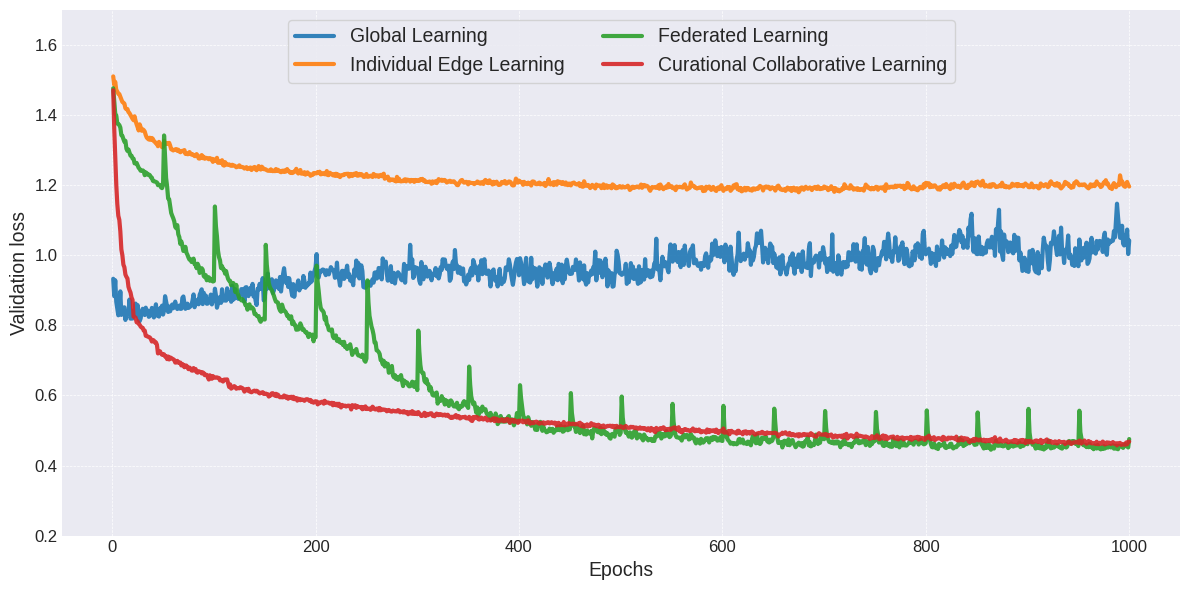

In [92]:
import pandas as pd
import matplotlib.pyplot as plt

# Use a seaborn style for improved aesthetics
plt.style.use('seaborn-darkgrid')

# Load CSV files
gl_results   = pd.read_csv("global_learning_results_torch.csv")
idel_results = pd.read_csv("individual_learning.csv")
fl_results   = pd.read_csv("FL_results.csv")
cl_results   = pd.read_csv("collaborative_learning_resultsvv2.csv")
cl_results2   = pd.read_csv("CL results.csv")

# Extract data (assuming epochs are consistent across datasets)
epochs         = cl_results["Epoch"]
gl_val_loss    = gl_results["Validation Loss"]
idel_val_loss  = idel_results["Validation Loss"]
fl_val_loss    = fl_results["Validation Loss"]
cl_val_loss    = cl_results["Train Loss"]  # It seems you're plotting CL's "Train Loss" as validation
cl_val_loss2    = cl_results2["Train Loss"]  # It seems you're plotting CL's "Train Loss" as validation

# Increase marker size and line width for clarity
markersize = 7
linewidth  = 3

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot validation curves with markers only every 100 epochs
ax.plot(epochs, gl_val_loss,   label="Global Learning",       linewidth=linewidth, alpha=0.9)
ax.plot(epochs, idel_val_loss, label="Individual Edge Learning",  linewidth=linewidth, alpha=0.9)
ax.plot(epochs, fl_val_loss,   label="Federated Learning",  linewidth=linewidth, alpha=0.9)
# ax.plot(epochs, cl_val_loss,   label="Collaborative Learning", linewidth=linewidth, alpha=0.9)
# ax.plot(epochs, cl_val_loss,   label="Collaborative Learning", linewidth=linewidth, alpha=0.9)
ax.plot(epochs, cl_val_loss2,   label="Curational Collaborative Learning", linewidth=linewidth, alpha=0.9)

# Labeling and title
ax.set_xlabel("Epochs", fontsize=14)
ax.set_ylabel("Validation loss", fontsize=14)
# ax.set_title("Validation Loss Comparison Across Learning Schemes", fontsize=14)

# Legend settings
ax.legend(loc='upper center', ncol=2, fontsize=14, frameon=True)

# Optionally, adjust y-axis limits if needed
ax.set_ylim(0.2, 1.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig("/home/roo/Desktop/Jaffar/CL/validation_loss_comparison.png", dpi=300, bbox_inches='tight')

# Grid settings for consistency
ax.grid(True, linestyle='--', linewidth=0.5)
# Save the figure as a PNG
plt.savefig("validation_loss_comparison.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()

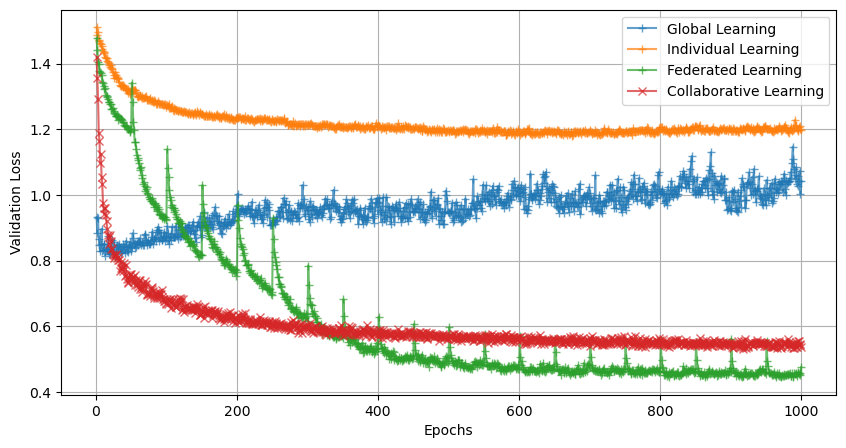

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Load both CSV files
gl_results = pd.read_csv("global_learning_results_torch.csv")
idel_results = pd.read_csv("individual_learning.csv")
fl_results = pd.read_csv("federated_learning_resultsv2.csv")
cl_results = pd.read_csv("collaborative_learning_resultsvv2.csv")

# Extract Train Loss
epochs = cl_results["Epoch"]
gl_train_loss = gl_results["Validation Loss"]
idel_train_loss = idel_results["Validation Loss"]
fl_train_loss = fl_results["Validation Loss"]
cl_train_loss = cl_results["Validation Loss"]
# cl_train_loss2 = cl_results2["Validation Loss"]
# cl_train_loss3 = cl_results3["Train Loss"]

# Plot both loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, gl_train_loss, label="Global Learning", linestyle='-', marker='+', alpha=0.7)
plt.plot(epochs, idel_train_loss, label="Individual Learning", linestyle='-', marker='+', alpha=0.7)
plt.plot(epochs, fl_train_loss, label="Federated Learning", linestyle='-', marker='+', alpha=0.7)
plt.plot(epochs, cl_train_loss, label="Collaborative Learning", linestyle='-', marker='x', alpha=0.7)
#plt.plot(epochs, cl_train_loss2, label="Collaborative Learning", linestyle='-', marker='o', alpha=0.7)
# plt.plot(epochs, cl_train_loss3, label="Collaborative Learning", linestyle='-', marker='^', alpha=0.7)

# Graph settings
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
# plt.title("Comparison of Train Loss: Federated Learning vs. Collaborative Learning")
plt.legend()
plt.grid()
plt.show()
